<a href="https://colab.research.google.com/github/MiroDur/MuScat_Miro/blob/master/DataReconstructionSIngleGlassBeadInPVA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
#!pip install phantominator
!pip install -U tensorflow-addons

     |████████████████████████████████| 706kB 13.4MB/s 
  Found existing installation: tensorflow-addons 0.8.3
    Uninstalling tensorflow-addons-0.8.3:
      Successfully uninstalled tensorflow-addons-0.8.3


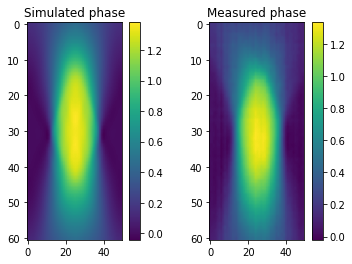

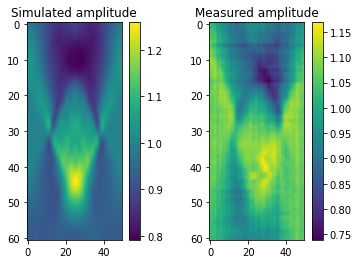

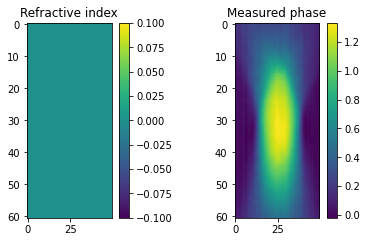

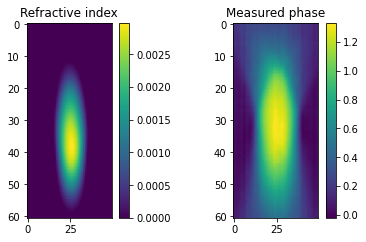

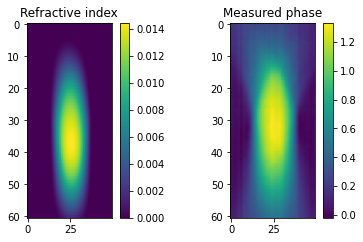

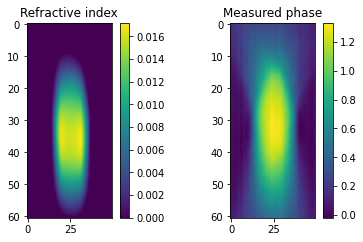

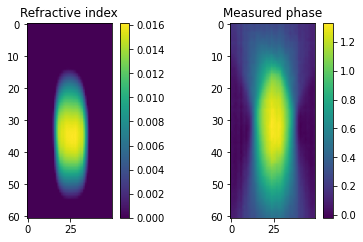

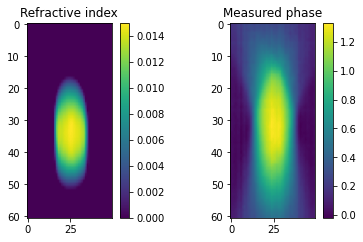

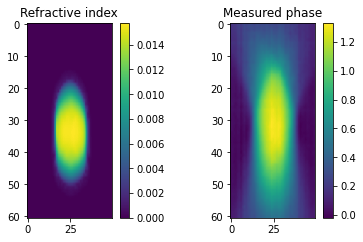

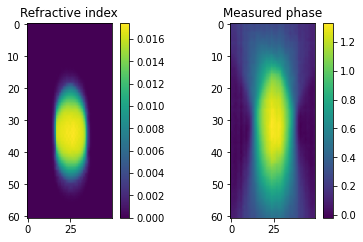

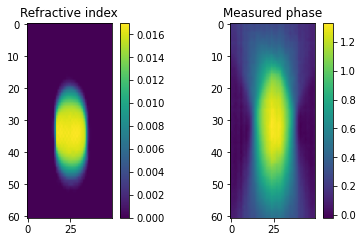

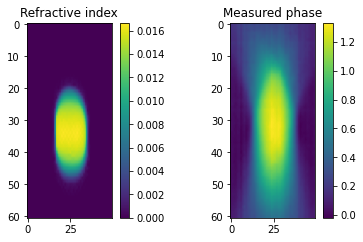

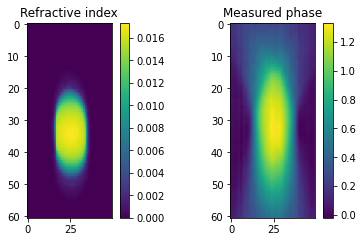

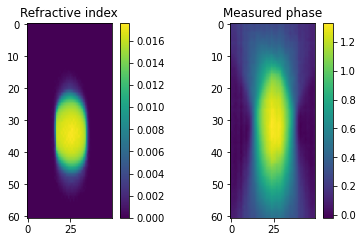

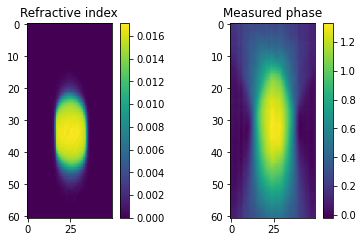

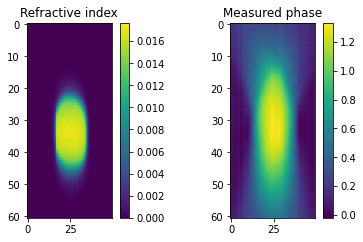

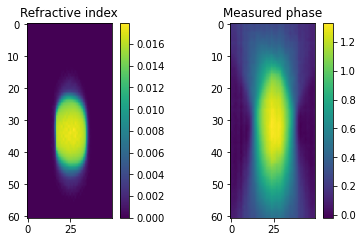

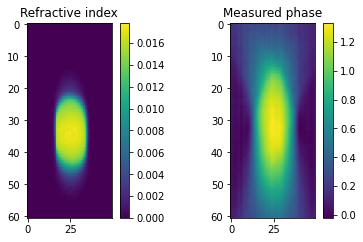

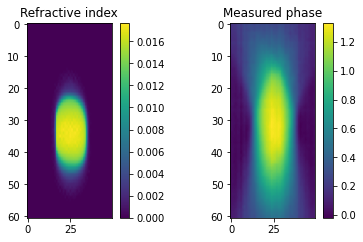

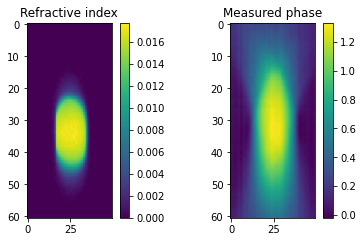

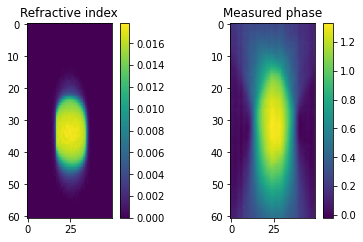

In [ ]:
import sys
sys.path.append('/content/drive/My Drive/MuScat')
from MuScatObject import MuScatObject
from MuScatField import MuScatField
from MuScatParameters import MuScatParameters
from MuScatMicroscopeSim import MuScatMicroscopeSim
import tensorflow as tf
import tensorflow_addons as tfa
import time
import numpy as np
import matplotlib.pyplot as plt
import scipy.io


# %% Load data
start = time.time()
zStackMeasured = np.array(scipy.io.loadmat(r'/content/drive/My Drive/MuScat/SingleBeadGlassPVA.mat')['croppedSingleBeadGlassE'])
#np.array(scipy.io.loadmat(r'/content/drive/My Drive/MuScat/GlassBeadNOA63_NAc09.mat')['BeadNA09e'])
#np.array(scipy.io.loadmat(r'/content/drive/My Drive/MuScat/TwoBeadsGlassNOA63.mat')['croppedTwoBeads'])
#np.array(scipy.io.loadmat(r'/content/drive/My Drive/MuScat/cell3.mat')['croppedCell3'])
#np.array(scipy.io.loadmat(r'/content/drive/My Drive/MuScat/RBC.mat')['croppedRBC'])
#np.array(scipy.io.loadmat(r'/content/drive/My Drive/MuScat/GlassBeadNOA63.mat')['croppedBead'])
#np.array(scipy.io.loadmat(r'/content/drive/My Drive/MuScat/TwoBeads2.mat')['TwoBeads2'])
#np.array(scipy.io.loadmat(r'/content/drive/My Drive/MuScat/GlassPVAFB.mat')['croppedGlassPVAFB1'])
#np.array(scipy.io.loadmat(r'/content/drive/My Drive/MuScat/SingleBeadGlassPVA.mat')['croppedSingleBeadGlassE'])

# zStackMeasured *= np.exp(-1j*3)
zStackMeasured *= 1/10000    # Normalize amplitude (different for each dataset)
# reorder from matlab indexing to python
zStackMeasured = np.conj(np.transpose(zStackMeasured, [2, 0, 1]))
# Data measured with older Q-phase software may be recorded in different order
# therefore some dataset need to be reorded in z direction
zStackMeasured = zStackMeasured[::1, :, :]
# crop dataset
zStackMeasured = zStackMeasured[:, :, :]
# z-samplig of the z-Stack measurement = not all measured images have to be used
zsampling = 1
# transversal sampling, applies for simulation as well  
xsampling = 1
zStackMeasured = zStackMeasured[::zsampling, ::xsampling, ::xsampling]
zStckShape = zStackMeasured.shape
zStackMeasured = tf.cast(tf.reshape(tf.constant(zStackMeasured), [1, 
                                                          zStckShape[0], 
                                                          zStckShape[1], 
                                                          zStckShape[2]]),
                         tf.complex64)
centerInd = np.int32(zStckShape[1]/2)
# ==========================================================
# MAKE SURE THAT X AND Y SIZE OF THE GRID FOR SIMULATION IS EVEN!!!
# I probably assumed that in the implementation from the begining
# ==========================================================

# NOA63 glue - refractive index = 1.5559 at 650nm
# soda-lime glass - refractive index = 1.5210 at 650nm - questionable for my spheres
# PVP (gel) - refractive index = 1.5245 at 650nm
# PVA (gel) - refractive index = 1.4757 at 650nm

refrIndM = 1.4857

# Illumination in most of the cases with 20x objective with NA=0.5
# Detection with 40x objective NA=0.95
parameters = MuScatParameters(0.650,        # wavelength in vacuum
                              [zStckShape[0]*zsampling, zStckShape[1], zStckShape[2]], # gridSize [z, x ,y]
                              0.15787*xsampling,          # dx
                              0.15787*xsampling,          # dy
                              0.2*refrIndM,          # dz
                              refrIndM,          # refractive index in medium
                              0.5,          # NAc
                              0.95)          # NAo
regLambdaL1 = 0.0005
regLambdaL2 = 0.#1
regLambdaTV = 0.0001
learnRate = 0.08

imagingSim = MuScatMicroscopeSim(parameters)

# Reference arm objective position can be optimized
refShifts = tf.cast(tf.Variable([[0.01,-0.008]],
                                constraint=tf.keras.constraints.MinMaxNorm(
                                    min_value=-0.2,
                                    max_value=0.2,
                                    rate=1.0,
                                    axis=0)),
                     tf.float32)
# refShifts =tf.cast(tf.constant([[0.1,-0.16]]), tf.float32)

# Initialize Illumination and detection part
imagingSim.Illumination()
imagingSim.Detection()

# Initialize object containing refractive index Variable-Tensor to be optimized
optimizedObject = MuScatObject(parameters)

# Define focal positions for z-Stack creation
zPositions = optimizedObject.realzzz[::zsampling,0,0] - optimizedObject.realzzz[0,0,0]

# Create object that will be imaged in case of pure simulation
imagedObject = MuScatObject(parameters)
imagedObject.GenerateBead(2., 1.52)

# Simulate light propagation through defined imagedObject
fieldSimulated = MuScatField(imagingSim.planeWaves, parameters).ComputeMuScat(
    imagedObject, method='MLB')

# Generate z-Stack measurement with CCHM from simulated scattered field
zStackSimulated = imagingSim.CCHMImaging(fieldSimulated, zPositions, refShifts) 

# in case of imaging a Bead, check validity of set parameters based on the 
# comparison of simulated and measured data
plt.figure(11)
plt.subplot(121),plt.colorbar(plt.imshow(
    np.angle(zStackSimulated[0, :, centerInd, :]),
    aspect=parameters.dz/parameters.dx))
plt.title('Simulated phase')
plt.subplot(122),plt.colorbar(plt.imshow(
    np.angle(zStackMeasured[0, :, centerInd, :]),
    aspect=parameters.dz/parameters.dx))
plt.title('Measured phase')
plt.figure(12)
plt.subplot(121),plt.colorbar(plt.imshow(
    np.abs(zStackSimulated[0, :, centerInd, :]),
    aspect=parameters.dz/parameters.dx))
plt.title('Simulated amplitude')
plt.subplot(122),plt.colorbar(plt.imshow(
    np.abs(zStackMeasured[0, :, centerInd, :]),
    aspect=parameters.dz/parameters.dx))
plt.title('Measured amplitude')
plt.show()

# in case of Adam or other TF optimizers use this regularizer func. to
# specify L1 and L2 regularization
regularizer = tf.keras.regularizers.L1L2(regLambdaL1, regLambdaL2)
#opt = tf.keras.optimizers.Adam(learning_rate=learnRate)

# Some optimizers such as Yogi have l1 and l2 as parameters
# Yogi is steepest gradient descent based optimizer
opt = tfa.optimizers.Yogi(learning_rate=learnRate,
                          l1_regularization_strength = regLambdaL1,
                          l2_regularization_strength = regLambdaL2)

def regTV(variable, parameter):
    diffZ = (variable - tf.roll(variable,1,0))
    diffX = (variable - tf.roll(variable,1,1))
    diffY = (variable - tf.roll(variable,1,2))
    return parameter * tf.reduce_sum(tf.sqrt(diffZ**2 + diffX**2 + diffY**2 + \
                                             tf.keras.backend.epsilon()))


@tf.function
def loss_fn(zStackSimulated, zStackMeasured):
    return tf.reduce_mean(tf.abs(zStackMeasured - zStackSimulated)**2) + regTV(optimizedObject.RIDistrib, regLambdaTV)
        #regularizer(optimizedObject.RIDistrib) #+ regTV(optimizedObject.RIDistrib, 0.0005)


loss = lambda: loss_fn(imagingSim.CCHMImaging(
    MuScatField(imagingSim.planeWaves, parameters).ComputeMuScat(
        optimizedObject, method='MLB'),
        zPositions,
        refShifts),
        zStackMeasured)

lossF = [ ]
for i in range(100):
    opt_op = opt.minimize(loss, var_list=[optimizedObject.RIDistrib, refShifts])
    if i%5==0:
        #lossF.append(loss().numpy())
        plt.figure(1)
        plt.subplot(121),plt.colorbar(plt.imshow(
            optimizedObject.RIDistrib[:, centerInd, :],
            aspect=parameters.dz/parameters.dx))
        plt.title('Refractive index')
        plt.subplot(122),plt.colorbar(plt.imshow(
            np.angle(zStackMeasured[0,:, centerInd, :]),
            aspect=parameters.dz/parameters.dx))
        plt.title('Measured phase')
        plt.tight_layout(pad=3.0)
        #plt.subplot(133),plt.plot(lossF)
        plt.show()

print(time.time()-start)

In [ ]:
!pip install pyevtk
from pyevtk.hl import gridToVTK
from pyevtk.hl import imageToVTK
#gridToVTK(
#    "./RIDistrib",
#    imagedObject.realzzz.numpy(),
#    imagedObject.realxxx.numpy(),
#    imagedObject.realyyy.numpy(),
#    pointData={"RIDistrib": optimizedObject.RIDistrib.numpy()},
#    )

imageToVTK(
    "./RIDistrib",
    spacing = (parameters.dz/parameters.dx,1.0,1.0),
    cellData={"RIDistrib": optimizedObject.RIDistrib.numpy()},
    
)


'/content/RIDistrib.vti'

In [ ]:
zStckShape

(80, 48, 48)

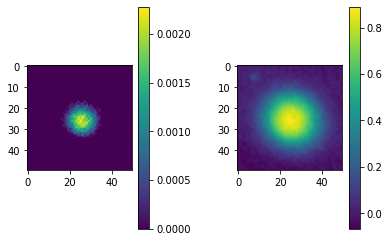

In [20]:
plt.subplot(121),plt.colorbar(plt.imshow(optimizedObject.RIDistrib[50, :, :]))
plt.subplot(122),plt.colorbar(plt.imshow(np.angle(zStackMeasured[0, 50, :, :])))
plt.tight_layout(pad=3.0)
